In [23]:
#get dataframe of tweet_id and user_id
import pandas as pd
import csv
from twython import Twython
import time
from collections import defaultdict

df = pandas.read_csv('gamergate_tweets.csv')
user_ids = df['user_id'].tolist()[:5000]

# Consumer & Auth keys and tokens for authentication
CONSUMER_KEY = "48r56upQvsnTiSDfY4CNwIpCQ"
CONSUMER_SECRET = "VqZhFW7GqogdKXJnpuS0umVe211bFgoCdaQlRdRMayvrbdDh3k"
OAUTH_TOKEN = "18000528-Scl8a1pLinqP4KWtaa3f8EN0M1vqAGTyYXMtsLIGm"
OAUTH_TOKEN_SECRET = "NcIvLeqVbwwBegabvo7946FVIaDN0CAaJ7aS2aV7pZFzC"

twitter = Twython(
    CONSUMER_KEY, CONSUMER_SECRET,
    OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

#%run Get\ Tweets.ipynb
###########
'''
start = 0
end = 100
tweet_list = []
while end <= 5000:
    id_list = df["tweet_id"].tolist()
    current = id_list[start:end]
    tweet = twitter.lookup_status(id=current)
    start += 100
    end += 100
    for t in tweet:
        each_tweet = []
        each_tweet.append(t['user']['id'])
        each_tweet.append(t["retweet_count"])
        each_tweet.append(t["favorite_count"])
        if t["entities"]['urls'] != []:
            each_tweet.append(1)
        else: each_tweet.append(0)
        if t["entities"]["user_mentions"] == []:
            each_tweet.append([])
        else: 
            y = 0
            mentionlist = []
            while y < len(t["entities"]["user_mentions"]):
                mentionlist.append((t["entities"]["user_mentions"])[y].items()[2][1])
                y+=1
            each_tweet.append(mentionlist)
        each_tweet.append(t["text"])
        tweet_list.append(each_tweet)
tweets_df = pandas.DataFrame(tweet_list, columns=["User ID", "Retweets", "Favorites", "Has_url", "Mentions", "Text"])
###########

# check rate limit
# twitter.get_application_rate_limit_status()['resources']['followers']
'''

'\nstart = 0\nend = 100\ntweet_list = []\nwhile end <= 5000:\n    id_list = df["tweet_id"].tolist()\n    current = id_list[start:end]\n    tweet = twitter.lookup_status(id=current)\n    start += 100\n    end += 100\n    for t in tweet:\n        each_tweet = []\n        each_tweet.append(t[\'user\'][\'id\'])\n        each_tweet.append(t["retweet_count"])\n        each_tweet.append(t["favorite_count"])\n        if t["entities"][\'urls\'] != []:\n            each_tweet.append(1)\n        else: each_tweet.append(0)\n        if t["entities"]["user_mentions"] == []:\n            each_tweet.append([])\n        else: \n            y = 0\n            mentionlist = []\n            while y < len(t["entities"]["user_mentions"]):\n                mentionlist.append((t["entities"]["user_mentions"])[y].items()[2][1])\n                y+=1\n            each_tweet.append(mentionlist)\n        each_tweet.append(t["text"])\n        tweet_list.append(each_tweet)\ntweets_df = pandas.DataFrame(tweet_list, c

In [3]:
# GET followers/list
def get_follower_list(twitter, user_id):
    followers = []
    cursored = twitter.cursor(twitter.get_followers_list, id=user_id)
    for follower in cursored:
        followers.append(follower)
    return followers

# GET users/lookup
def get_user_lookup(twitter, current):
    user_obj = twitter.lookup_user(user_id=current)
    return user_obj
    
# GET followers/ids
def get_follower_ids(twitter, user_id):
    followers = []
    cursored = twitter.cursor(twitter.get_followers_ids, id=user_id)
    for follower in cursored:
        followers.append(follower)
    return followers

In [4]:
user_list = []
start = 0
end = 100
while end <= 5000:
    current = user_ids[start:end]
    start += 100
    end += 100
    users = get_user_lookup(twitter, current)
    for i in range(0, len(users)):
        each_user = []
        each_user.append(user_ids[i]) # user[0] = user_id
        each_user.append(users[i]['followers_count']) # user[1] = follower count
        each_user.append(users[i]['favourites_count'])
        each_user.append(users[i]['location'])
        user_list.append(each_user)

In [5]:
users_df = pandas.DataFrame(user_list, columns=["User ID", "Follower Count", "Favourites Count", "Location"])
tweets_df = pandas.read_csv("all_tweets.csv")
print tweets_df.info()
#print users_df.sort_values(["Follower Count", "Favourites Count",], ascending=[False, False])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 429367 entries, 0 to 429366
Data columns (total 9 columns):
User ID        270866 non-null object
Retweets       270873 non-null float64
Favorites      270873 non-null float64
Has_url        270871 non-null float64
Mentions       270852 non-null object
Text           270813 non-null object
Polarity       206309 non-null float64
Popularity     206309 non-null float64
numMentions    206309 non-null float64
dtypes: float64(6), object(3)
memory usage: 32.8+ MB
None


/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (0,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans
import seaborn as sns
from scipy import cluster
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%pylab inline
%matplotlib inline

def evaluate_clusters(X, max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_
    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')

Populating the interactive namespace from numpy and matplotlib


/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


n_samples: 206272, n_features: 30
[u'adobe', u'anti', u'bad', u'bullying', u'chriswarcraft', u'chsommers', u'clickhole', u'ethics', u'femfreq', u'gaming', u'gawker', u'gg', u'good', u'harassment', u'hate', u'look', u'media', u'nero', u'new', u'people', u'right', u'sargon_of_akkad', u'stop', u'support', u'theralphretort', u'think', u'threats', u'time', u'video', u'women']


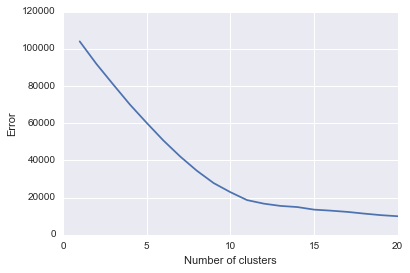

In [123]:
text_list = tweets_df.dropna().Text.values
#text_list = tweets_df.Text.dropna().values # follow the same index as tweets_df
vectorizer = TfidfVectorizer(max_df=.9, max_features=25,
                             min_df=3, stop_words='english',
                             use_idf=True)

stop_words = list(vectorizer.get_stop_words())
stop_words.append('like')
stop_words.append('just')
stop_words.append('tweets')
stop_words.append('twitter')
stop_words.append("gamers")
stop_words.append("gamer")
stop_words.append("games")
stop_words.append("game")
stop_words.append("month")
stop_words.append("hours")
stop_words.append("20")
stop_words.append("want")
stop_words.append("don")
stop_words.append("did")
stop_words.append("ve")
stop_words.append("really")
stop_words.append("day")
stop_words.append("let")
stop_words.append("read")
stop_words.append("know")

vect = TfidfVectorizer(max_df=.9, max_features=30,
                             min_df=3, stop_words=stop_words, 
                             use_idf=True, analyzer='word')

X = vect.fit_transform(text_list)
X_prime = vectorizer.fit_transform(text_list)
print("n_samples: %d, n_features: %d" % X.shape)
print vect.get_feature_names()

svd = TruncatedSVD(10)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X = lsa.fit_transform(X)
#explained_variance = svd.explained_variance_ratio_.sum()
#print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

evaluate_clusters(X,20)

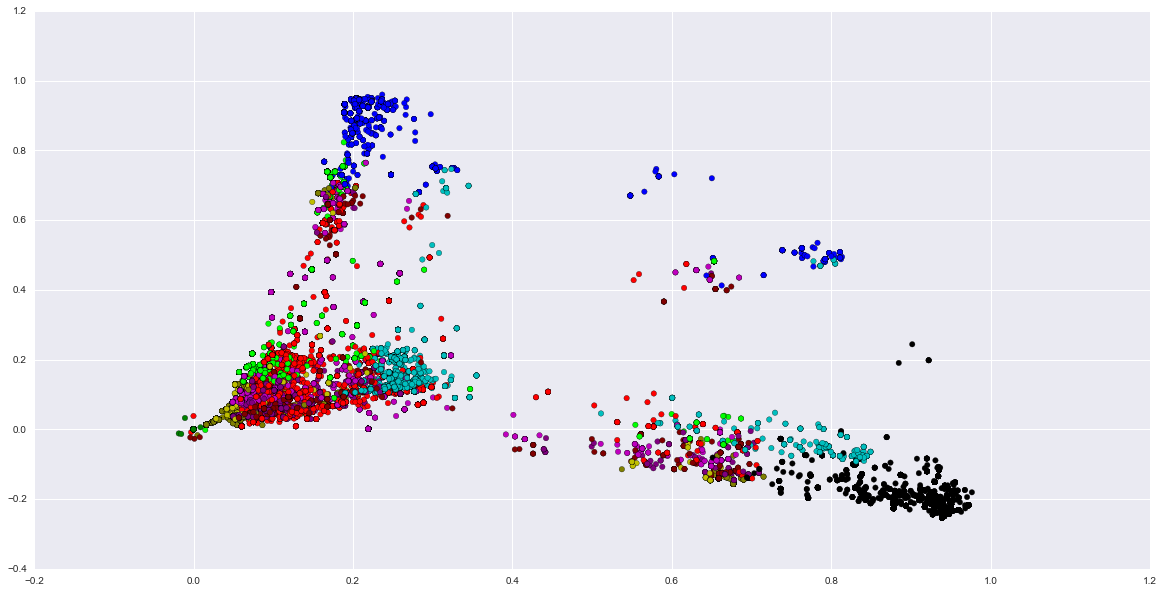

In [87]:
#kmeans = KMeans(n_clusters=12, init='k-means++', max_iter=100, n_init=1, verbose=True)
#y_pred = kmeans.fit(X)
kmeans = MiniBatchKMeans(n_clusters=11, init='k-means++', n_init=1,
                     init_size=1000, batch_size=1000, verbose=False)
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

#kmeans = KMeans(init='k-means++', n_clusters=7, n_init=20)
y_pred = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_
colors = np.array([x for x in ('b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'lime', 'maroon', 'olive', 'pink')])
colors = np.hstack([colors] * 20)

plt.figure(figsize=(20, 10))
plt.scatter(X[:, 0], X[:, 1], s=30, c=colors[y_pred].tolist())
#print "labels:" , labels
#print "error:", error
#print "centroids:", centroids

In [108]:
tweets_df[tweets_df.Text.isnull()]
#tweets_df[pd.isnull(tweets_df)]
print tweets_df.info()
print tweets_df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 429367 entries, 0 to 429366
Data columns (total 9 columns):
User ID        270866 non-null object
Retweets       270873 non-null float64
Favorites      270873 non-null float64
Has_url        270871 non-null float64
Mentions       270852 non-null object
Text           270813 non-null object
Polarity       206309 non-null float64
Popularity     206309 non-null float64
numMentions    206309 non-null float64
dtypes: float64(6), object(3)
memory usage: 32.8+ MB
None
(429367, 9)


In [136]:
#from sklearn.metrics import silhouette_samples, silhouette_score
#silh_avg = silhouette_score(X, y_pred)
tags = np.unique(labels)
nonan_tweets_df = tweets_df.dropna()
nonan_tweets_df['Labels'] = pd.Series(labels, index=nonan_tweets_df.index)
#print nonan_tweets_df.info()
grouped = nonan_tweets_df.groupby('Labels')
print grouped.size()
clusters = []
pop_users = []
for t in tags:
    clusters.append(pd.DataFrame(grouped.get_group(t)).sort_values("Popularity", ascending=False))
    pop_users.append(pd.DataFrame(grouped.get_group(t)).sort_values("Popularity", ascending=False)[:5])
for c in clusters:
    print c.info()

Labels
0      9867
1     91636
2     20243
3     14811
4     14182
5      9570
6     10746
7     11742
8      8238
9      8976
10     6261
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9867 entries, 343532 to 429316
Data columns (total 10 columns):
User ID        9867 non-null object
Retweets       9867 non-null float64
Favorites      9867 non-null float64
Has_url        9867 non-null float64
Mentions       9867 non-null object
Text           9867 non-null object
Polarity       9867 non-null float64
Popularity     9867 non-null float64
numMentions    9867 non-null float64
Labels         9867 non-null int32
dtypes: float64(6), int32(1), object(3)
memory usage: 809.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 91636 entries, 20515 to 343334
Data columns (total 10 columns):
User ID        91636 non-null object
Retweets       91636 non-null float64
Favorites      91636 non-null float64
Has_url        91636 non-null float64
Mentions       91636 non-null objec

/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [137]:
pop_users[0]
#follower_ids = defaultdict(list)
#for i in pop_users[0]:
#    follower_ids[i] = get_follower_ids(twitter, i)

#print pop_users[0]
#print twitter.get_application_rate_limit_status()['resources']['followers']

,User ID,Retweets,Favorites,Has_url,Mentions,Text,Polarity,Popularity,numMentions,Labels
343532,113137765,434,354,0,"[8936082, 2803191]","Doing business with @gawker, after they just t...",0.6880,788,2,0
336839,6160792,287,372,0,[],This is the reckoning the world has been waiti...,0.0000,659,0,0
11568,3.34922e+08,287,344,1,"[44123487, 17681505, 411001754]","Watch Jimmy Kimmel take down Gawker's ""citizen...",0.0000,631,3,0
384123,6160792,295,291,1,[],"NEW, by me—Gawker: ‘dishonest fascists’ of ‘c...",0.5905,586,0,0
336608,6160792,243,286,1,[],"Gawker: we got busted being total douches, and...",0.6640,529,0,0


In [12]:
print polar_user_df.info()
follower_ids = defaultdict(list)
i = 0
remaining = twitter.get_application_rate_limit_status()['resources']['followers']['/followers/ids']['remaining']
while i < len(polar_users):
    print polar_users.iloc[i]
    if remaining < 1:
        print "start waiting"
        time.sleep(930)
        print "done waiting"
        remaining = twitter.get_application_rate_limit_status()['resources']['followers']['/followers/ids']['remaining']
    else:
        follower_ids[polar_users.iloc[i]] = get_follower_ids(twitter, polar_users.iloc[i])
        remaining = twitter.get_application_rate_limit_status()['resources']['followers']['/followers/ids']['remaining']
        i += 1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 1773 to 2448
Data columns (total 4 columns):
User ID       21 non-null int64
Mentions      21 non-null object
Polarity      21 non-null int64
Popularity    21 non-null int64
dtypes: int64(3), object(1)
memory usage: 840.0+ bytes
None
2801289353
14 2801289353
2368624716
12 2368624716
1317712621
11 1317712621
16088388
10 16088388
1498976455
9 1498976455
104519838
8 104519838
1499808391
6 1499808391
2788941283
5 2788941283
24610050
1 24610050
2837175356
0 2837175356
857720059
start waiting
done waiting


TwythonError: HTTPSConnectionPool(host='api.twitter.com', port=443): Read timed out. (read timeout=None)

In [14]:
print len(follower_ids.keys())
# find out tweets that belongs to followers of the 21 popular users
# make a df of all the tweets for each popular user
follower_dfs = []
for p in polar_users:
    df = tweets_df.loc[tweets_df['User ID'].isin(follower_ids[p])]
    follower_dfs.append(df)
    

21


In [19]:
# pay attention to 574962273, 1499808391, 854203626
count_list = []
polar_mean = []
for i in range(len(follower_dfs)):
    count_list.append(follower_dfs[i].shape[0])
    polar_mean.append(follower_dfs[i].Polarity.mean())

polar_user_df["Follower Tweets Count"] = np.array(count_list)
polar_user_df["Follower Polarity Mean"] = np.array(polar_mean)
print polar_user_df.info()

/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Minying/envs/cs591-datamining/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, 1773 to 2448
Data columns (total 6 columns):
User ID                   21 non-null int64
Mentions                  21 non-null object
User Polarity             21 non-null int64
Popularity                21 non-null int64
Follower Tweets Count     21 non-null int64
Follower Polarity Mean    9 non-null float64
dtypes: float64(1), int64(4), object(1)
memory usage: 1.1+ KB
None


In [20]:
polar_user_df.rename(index=str, columns={"Polarity": "User Polarity"}, inplace=True)